<a href="https://colab.research.google.com/github/hubertwel/paragraph-similarity/blob/main/paragraph-similarity/paragraph_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

test_data_dir: /content/drive/MyDrive/Colab Notebooks/data/gouvfr/CorpusRandomTwitter
train_corpus (the beginning):  [['rt', 'americanidol', 'watch', 'as', 'ddlovato', 'gives', 'an', 'amazing', 'performance', 'of', 'her', 'single', 'stonecold', 'demionidol'], ['rt', 'dipti_varun', 'varun', 'dhawan', 'junaid', 'is', 'rookie', 'cop', 'and', 'heâ', 'kind', 'of', 'discovering', 'himself', 'as', 'the', 'movie', 'goes', 'on', 'varun_dvn', 'dishoom']]
train_corpus length 1000
train_corpus_tagged (the beginning):  [TaggedDocument(words=['rt', 'americanidol', 'watch', 'as', 'ddlovato', 'gives', 'an', 'amazing', 'performance', 'of', 'her', 'single', 'stonecold', 'demionidol'], tags=[0]), TaggedDocument(words=['rt', 'dipti_varun', 'varun', 'dhawan', 'junaid', 'is', 'rookie', 'cop', 'and', 'heâ', 'kind', 'of', 'discovering', 'himself', 'as', 'the', 'movie', 'goes', 'on', 'varun_dvn', 'dishoom'], tags=[1])]
test_corpus (the beginning):  [['live', 'morning', 'news', 'weather', 'and', 'traffic', 'upd

[I 2021-02-21 23:59:51,289] A new study created in memory with name: no-name-a52799f4-743a-4bea-abc1-f62803bec3d5


first_ranks_test:  [128, 763, 943, 492, 994, 288, 349, 714, 238, 131, 759, 697, 814, 656, 662, 693, 582, 168, 87, 69, 611, 983, 208, 412, 340, 382, 312, 580, 507, 235, 935, 637, 647, 42, 494, 7, 145, 496, 262, 177, 545, 893, 686, 914, 50, 355, 671, 252, 76, 82, 206, 127, 535, 665, 194, 68, 954, 298, 389, 789, 470, 419, 82, 939, 64, 545, 766, 67, 738, 251, 781, 764, 96, 611, 22, 692, 285, 76, 131, 546, 808, 9, 131, 336, 503, 82, 137, 844, 647, 709, 578, 733, 221, 258, 768, 924, 131, 481, 147, 778, 634, 500, 131, 17, 660, 352, 141, 906, 657, 514, 791, 206, 95, 163, 506, 921, 117, 994, 593, 769, 647, 886, 700, 197, 438, 901, 131, 131, 463, 764, 225, 788, 39, 9, 576, 352, 591, 683, 438, 660, 292, 584, 226, 683, 715, 925, 177, 962, 240, 225, 196, 131, 454, 977, 390, 974, 277, 79, 47, 150, 566, 682, 399, 44, 352, 219, 259, 76, 414, 397, 967, 261, 330, 364, 720, 278, 223, 360, 775, 967, 628, 507, 545, 454, 199, 854, 78, 454, 426, 571, 452, 32, 925, 208, 318, 170, 234, 604, 430, 369, 795, 133,

[I 2021-02-22 00:00:30,158] Trial 0 finished with value: 0.11800000000000002 and parameters: {'penalty': 'l2', 'C': 0.9959663341109292, 'fit_intercept': False, 'intercept_scaling': 0.45523469251072984}. Best is trial 0 with value: 0.11800000000000002.
[I 2021-02-22 00:00:57,490] Trial 1 finished with value: 0.0 and parameters: {'penalty': 'l1', 'C': 0.5646465014163968, 'fit_intercept': True, 'intercept_scaling': 1.6599381549047858}. Best is trial 0 with value: 0.11800000000000002.
[I 2021-02-22 00:01:36,415] Trial 2 finished with value: 0.12200000000000003 and parameters: {'penalty': 'l2', 'C': 1.2536508229966201, 'fit_intercept': True, 'intercept_scaling': 1.8688129820291506}. Best is trial 2 with value: 0.12200000000000003.
[I 2021-02-22 00:02:16,448] Trial 3 finished with value: 0.11400000000000002 and parameters: {'penalty': 'l1', 'C': 0.7947549912840485, 'fit_intercept': False, 'intercept_scaling': 1.5937338003897346}. Best is trial 2 with value: 0.12200000000000003.
[I 2021-02-22

score:  [0.14 0.16 0.14 0.11 0.09 0.07 0.1  0.18 0.11 0.12]

Validation accuracy: 12.2
Train accuracy: 0.991
Test accuracy: 0.555

Number of classes:  629
True positives:  555
False positives:  445
False negatives:  445
True negatives:  627555

Normalized confusion matrix
[[1.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.33 0.   ... 0.   0.   0.  ]
 [0.   0.   1.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   1.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]



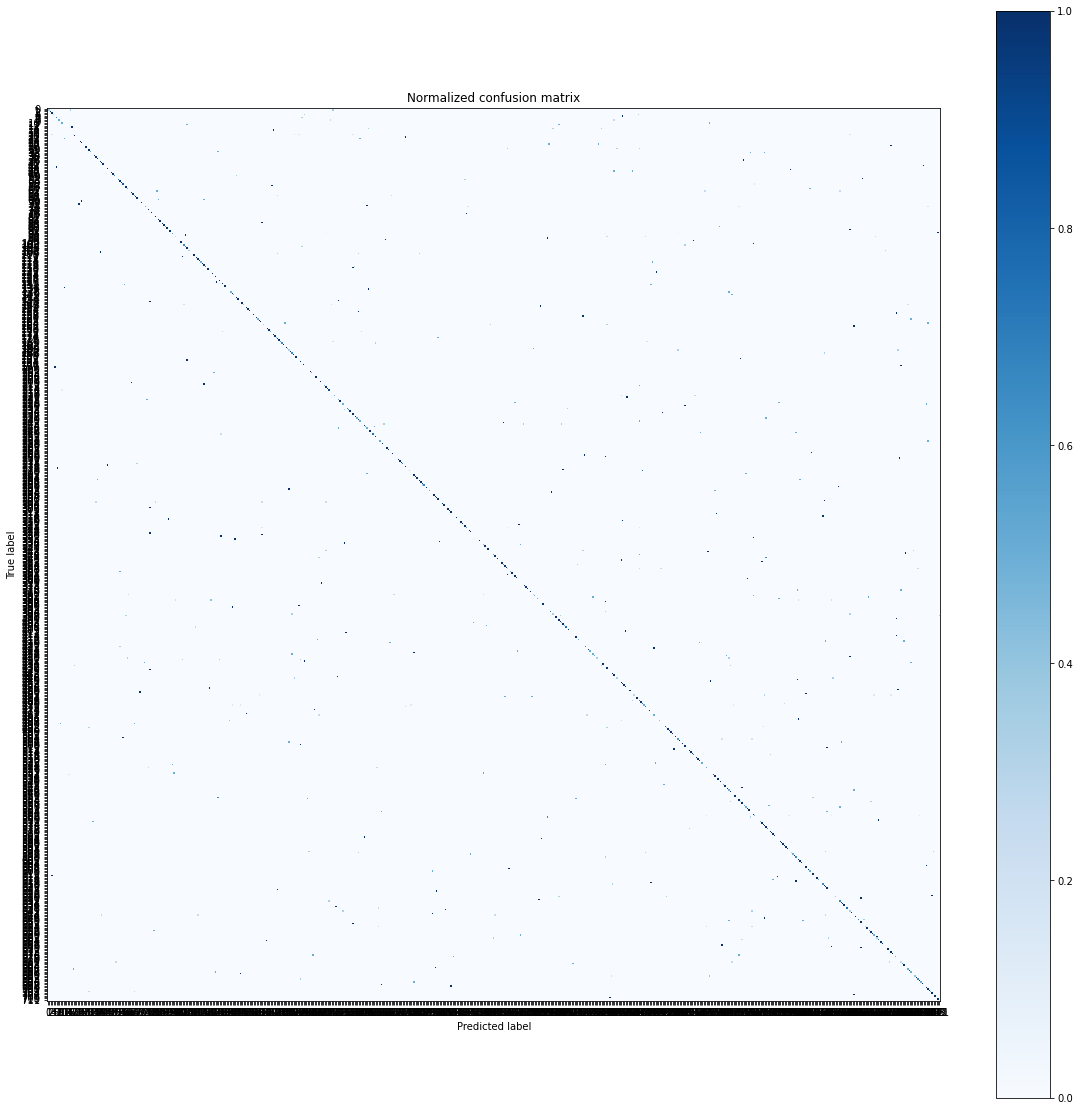

In [8]:
# Semantic similarity of tweets with Doc2Vec and Optuna
# Author: Hubert Welew https://github.com/hubertwel

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags, strip_multiple_whitespaces
from gensim.parsing.preprocessing import remove_stopwords, strip_short
from gensim.parsing.preprocessing import strip_non_alphanum, split_alphanum
from gensim.parsing.preprocessing import strip_punctuation
from gensim.utils import simple_preprocess
from gensim.utils import RULE_KEEP, RULE_DISCARD, RULE_DEFAULT
from gensim.test.utils import get_tmpfile
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils.multiclass import unique_labels
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np
import os
import smart_open
import csv
import collections
import random
import re
import optuna

def read_corpus(fname, tokens_only=False):
    with smart_open.open(fname, encoding="iso-8859-1") as f:
        csv_reader = csv.DictReader(f, quoting=csv.QUOTE_ALL)
        CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_multiple_whitespaces]
        for i, row in enumerate(csv_reader):
          line = row['x']
          line = remove_urls(line)
          line_list = preprocess_string(line, CUSTOM_FILTERS)
          line = " ".join(line_list)
          tokens = simple_preprocess(line)
          if tokens_only:
            yield tokens
          else:
            # For training data, add tags
            yield TaggedDocument(tokens, [i])

def remove_urls(text):
  text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE)
  return text

def trim_rule(word, count, min_count):
    stop_words = set(stopwords.words('english')) 
    # This rule is only used to prune vocabulary during the current method call,
    # so that documents can be printed with stopwords and with words of any length
    if ((word in stop_words) or (len(word) < 3)):
        return utils.RULE_DISCARD  # throw out
    else:
        return utils.RULE_DEFAULT  # apply default rule, i.e. min_count

# Define an objective function to be maximized
def objective(trial):
  # Optimize hyperparameters: 
    penalty = trial.suggest_categorical("penalty", ['l1', 'l2'])
    c = trial.suggest_float("C", 5e-1, 15e-1, log=True)
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
    intercept_scaling = trial.suggest_float("intercept_scaling", 1e-1, 2e0, log=True)
    clf = LogisticRegression(penalty=penalty, C=c, fit_intercept=fit_intercept, intercept_scaling=intercept_scaling, solver='liblinear', max_iter=300, class_weight='balanced', multi_class='auto')
  # Scoring method:
    k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
    score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=-1, scoring='accuracy')
    accuracy = np.mean(score)
    return accuracy

def main():    
  global X_train, y_train

  # Set file names for train and test data
  test_data_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/', 'gouvfr', 'CorpusRandomTwitter')
  print("test_data_dir: %s" % test_data_dir)
  train_file = os.path.join(test_data_dir, 'randomtweets3.txt')
  test_file = os.path.join(test_data_dir, 'randomtweets4.txt')

  train_corpus = list(read_corpus(train_file, tokens_only=True))
  train_corpus_tagged = list(read_corpus(train_file))
  test_corpus = list(read_corpus(test_file, tokens_only=True))

  print('train_corpus (the beginning): ', train_corpus[:2])
  print('train_corpus length %d' % len(train_corpus))
  print('train_corpus_tagged (the beginning): ', train_corpus_tagged[:2])
  print('test_corpus (the beginning): ', test_corpus[:2])
  print('test_corpus length %d' %len(test_corpus))
  print()

  # Build the model and its vocabulary
  model = Doc2Vec(dm=0, vector_size=80, min_count=3, epochs=50, hs=1, dbow_words=1, trim_rule=trim_rule)
  model.build_vocab(train_corpus_tagged)

  # Train the model on the train corpus
  model.train(train_corpus_tagged, total_examples=model.corpus_count, epochs=model.epochs)

  # Assess the model on the train corpus
  ranks = []
  first_ranks = []
  second_ranks = []
  inferred_vectors = []
  for doc_id in range(len(train_corpus_tagged)):
    inferred_vector = model.infer_vector(train_corpus_tagged[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    # sanity check (self-similarity)
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    first_ranks.append(sims[0][0])
    inferred_vectors.append(inferred_vector)
        
  print('sims: ', sims[:3])
  print('ranks: ', ranks)
  counter = collections.Counter(ranks)
  print(counter)
  print()

  # Test the model with one random document
  # Pick a random document from the test corpus and infer a vector from the model
  doc_id = random.randint(0, len(test_corpus) - 1)
  inferred_vector = model.infer_vector(test_corpus[doc_id])
  sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
  print('RANDOM TEST DOCUMENT ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))

  # Compare and print the most/second-most/third-most/median/least similar documents from the train corpus
  print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
  for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('THIRD-MOST', 2), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus_tagged[sims[index][0]].words)))

  # Save the model
  filename = get_tmpfile("parsim_doc2vec_model")
  model.save(filename)

  # Assess the model on the independent data set (test corpus)
  ranks_test = []
  first_ranks_test = []
  inferred_vectors_test = []
  for doc_id in range(len(test_corpus)):
    inferred_vector_test = model.infer_vector(test_corpus[doc_id])
    sims_test = model.dv.most_similar([inferred_vector_test], topn=len(model.dv))
    first_ranks_test.append(sims_test[0][0])
    inferred_vectors_test.append(inferred_vector_test)

  print('first_ranks_test: ', first_ranks_test)

  # Prepare vectors for cross validatiom
  tags_array_train = np.array(first_ranks)
  vectors_2Darray_train = np.array(inferred_vectors)
  tags_array_test = np.array(first_ranks_test)
  vectors_2Darray_test = np.array(inferred_vectors_test)
  y_train, X_train = tags_array_train, vectors_2Darray_train
  y_test, X_test = tags_array_test, vectors_2Darray_test

  # Create Optuna study
  study = optuna.create_study(direction="maximize")
  study.optimize(objective, n_trials=30)
  
  # Cross validation
  clf = LogisticRegression(penalty=study.best_params["penalty"], C=study.best_params["C"], fit_intercept=study.best_params["fit_intercept"], intercept_scaling=study.best_params["intercept_scaling"], solver='liblinear', max_iter=300, class_weight='balanced', multi_class='auto')
  k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
  score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=-1, scoring='accuracy')
  print('score: ', score)
  print()
  print('Validation accuracy: {}'.format(round(np.mean(score)*100, 3)))
  clf.fit(X_train, y_train) 
  y_pred = clf.predict(X_test)
  y_train_pred = clf.predict(X_train)
  print("Train accuracy: {:.3f}".format(accuracy_score(y_train, y_train_pred)))
  print("Test accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
  print()

  # Print TP, FP, FN, TN
  cm = confusion_matrix(y_test, y_pred)
  num_classes = len(unique_labels(y_test, y_pred))
  print('Number of classes: ', num_classes)
  true_positive = np.diag(cm)
  tp = sum(true_positive)
  print('True positives: ', tp)
  false_positive = []
  for x in range(num_classes):
    false_positive.append(sum(cm[:,x]) - cm[x,x])
  fp = sum(false_positive)
  print('False positives: ', fp)
  false_negative = []
  for x in range(num_classes):
    false_negative.append(sum(cm[x,:]) - cm[x,x])
  fn = sum(false_negative)
  print('False negatives: ', fn)
  true_negative = []
  for x in range(num_classes):
    # delete x-th row
    cm_without_row = np.delete(cm, x, 0)
    # delete x-th column
    cm_without_row_col = np.delete(cm_without_row, x, 1)
    result = list(map(sum, cm_without_row_col))
    true_negative.append(sum(result))
  
  tn = sum(true_negative)
  print('True negatives: ', tn)
  print()

  # Plot the confusion matrix
  np.set_printoptions(precision=2)
  title = "Normalized confusion matrix"
  fig, ax = plt.subplots(figsize=(20, 20))
  disp = plot_confusion_matrix(clf, X_test, y_test, display_labels=None, include_values=False, cmap=plt.cm.Blues, normalize='true', ax=ax)
  disp.ax_.set_title(title)
  print(title)
  print(disp.confusion_matrix)
  print()
  plt.show()

main()

In [ ]:
pip install -U scikit-learn

     |████████████████████████████████| 22.2MB 66.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
pip install optuna

     |████████████████████████████████| 296kB 8.4MB/s 
     |████████████████████████████████| 1.2MB 12.1MB/s 
     |████████████████████████████████| 81kB 7.6MB/s 
     |████████████████████████████████| 481kB 18.0MB/s 
     |████████████████████████████████| 143kB 31.5MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 112kB 35.4MB/s 
  Created wheel for alembic: filename=alembic-1.5.5-py2.py3-none-any.whl size=156597 sha256=3d5476cae858958aeb292270c85d2c7153993f4e001201d1414662c24630a3d2
  Stored in directory: /root/.cache/pip/wheels/74/3f/61/7de6e3cef766d2680a5d81b1a388286e640f6a681eb589d643
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=67f3ed455a1d43a16f5583ebf014487f0b67a40f4dffe5015d953b10d089abd2
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp36-none-any.whl size=11108 sha256=

In [3]:
pip install --pre --upgrade gensim

     |████████████████████████████████| 24.0MB 1.3MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
